REf: https://blog.paperspace.com/mean-average-precision/amp/

In [51]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
import pandas as pd
import imageio
import matplotlib.patches

## From prediction score to class label

Look to 10 samples, with positive and negative values

In [1]:
y_true = [
    "positive",
    "negative",
    "negative",
    "positive",
    "positive",
    "positive",
    "negative",
    "positive",
    "negative",
    "positive",
]


Look at to the prediction scores

In [2]:
pred_scores = [0.7, 0.3, 0.5, 0.6, 0.55, 0.9, 0.4, 0.2, 0.4, 0.3]


To convert the scores into a class label, a **threshold is used.** When the score is equal to or above the threshold, the sample is classified as one class. Otherwise, it is classified as the other class.

In [4]:
threshold = 0.5
y_pred = ["positive" if score >= threshold else "negative" for score in pred_scores]
y_pred

['positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive',
 'negative',
 'negative',
 'negative',
 'negative']

In [24]:
# confusion matrix returned by sklearn
confusion_matrix(y_true, y_pred)

array([[3, 1],
       [2, 4]])

In [25]:
# the format considered by sklearn
np.array([["TN", "FP"], ["FN", "TP"]])

array([['TN', 'FP'],
       ['FN', 'TP']], dtype='<U2')

In [26]:
# if we want extract just the values on each position
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

In [28]:
# precision
precision = precision_score(y_true, y_pred, pos_label="positive")
precision

0.8

In [30]:
# recall
recall = recall_score(y_true, y_pred, pos_label="positive")
recall

0.6666666666666666

> **NOTE:** A HIGH PRECISION indicate that the model is VERY GOOD in predict positive classes. A HIGH RECALL indicate the the model is VERY GOOD in predict the positive classes between all the positive classes available to predict.

There are some inputs needed to create the precision-recall curve:

- The ground-truth labels.
- The prediction scores of the samples.
- Some thresholds to convert the prediction scores into class labels.

In [33]:
threshold_range = np.arange(start=0.2, stop=0.7, step=0.05)
threshold_range

array([0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65])

In [35]:
def precision_recall_curve(y_true, pred_scores, threshold_range):
    precisions = []
    recalls = []
    for threshold in threshold_range:
        y_pred = ["positive" if value >= threshold else "negative" for value in pred_scores]
        precision = precision_score(y_true, y_pred, pos_label="positive")
        recall = recall_score(y_true, y_pred, pos_label="positive")
        precisions.append(precision)
        recalls.append(recall)

    return precisions, recalls

precisions, recalls = precision_recall_curve(y_true, pred_scores, threshold_range)

In [36]:
precisions, recalls

([0.6,
  0.5555555555555556,
  0.5555555555555556,
  0.5714285714285714,
  0.5714285714285714,
  0.8,
  0.8,
  1.0,
  1.0,
  1.0],
 [1.0,
  0.8333333333333334,
  0.8333333333333334,
  0.6666666666666666,
  0.6666666666666666,
  0.6666666666666666,
  0.6666666666666666,
  0.6666666666666666,
  0.5,
  0.3333333333333333])

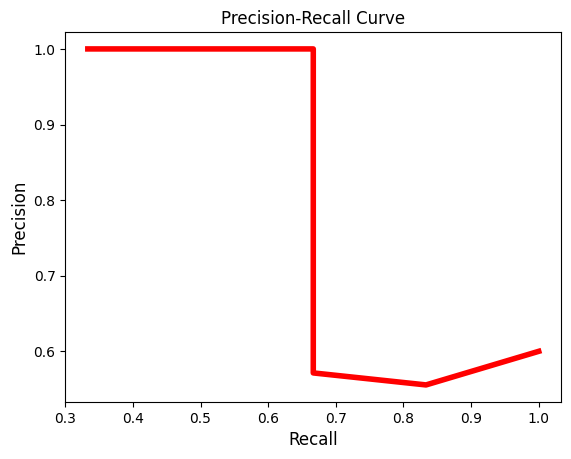

In [38]:
plt.plot(recalls, precisions, linewidth=4, color="red")
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision-Recall Curve")
plt.show()

So, we can look at the picture and decide what are the best values for precision and recall. But we have a better approach, using F1 score on each of those points.

A high F1 score indicate that we have a high precision and recall, otherwise a low F1 score indicate that we have an imbalanced situation between precision and recall

In [41]:
metric_evaluation = pd.DataFrame({"precision": precisions, "recall": recalls})

In [42]:
f1_values = 2 * ((np.array(precisions) * (np.array(recalls))) / (np.array(precisions) + np.array(recalls)))
f1_values

array([0.75      , 0.66666667, 0.66666667, 0.61538462, 0.61538462,
       0.72727273, 0.72727273, 0.8       , 0.66666667, 0.5       ])

In [45]:
metric_evaluation["f1"] = f1_values
metric_evaluation.sort_values(["f1"], ascending=False)

,precision,recall,f1
7,1.000000,0.666667,0.800000
0,0.600000,1.000000,0.750000
5,0.800000,0.666667,0.727273
6,0.800000,0.666667,0.727273
1,0.555556,0.833333,0.666667
2,0.555556,0.833333,0.666667
8,1.000000,0.500000,0.666667
3,0.571429,0.666667,0.615385
4,0.571429,0.666667,0.615385
9,1.000000,0.333333,0.500000


## Average Precision (AP)

AP is the weighted sum of precisions at each threshold where the weight is the increase in recall

$$
AP = \sum_{k=0}^{k=n-1}([Recalls(k) - Recalls(k+1)]*Precisions(k))
$$

- Recalls(n) = 0
- Precisions(n) = 1
- n = number of thresholds

In [47]:
ap = np.sum((np.array(recalls[:-1]) - np.array(recalls[1:])) * precisions[:-1])
ap

0.5259259259259259

This is all about calculate the Average Precision, the steps are:
- Generate the prediction scores using the model
- Convert the prediction scores to class labels
- Calculate the confusion matrix
- Calculate the precision and recall metrics
- Create the precision-recall curve
- Measure the average precision

## Intersection over Union (IoU)

Probably you'll never get the exactly same bounding box ground-truth on your predictions. And this is very difficult for us as humans evaluate all the predicted bounding boxes and also come up with a value that makes sense, in a consistent way.

To help us with that, we have a metric called Intersection over Union (IoU).

![iou](../imgs/iou.png)

![iou](../imgs/iou_examples.png)

Let's calculate the intersection over union metric!

In [50]:
def intersection_over_union(gt_box, pred_box):
    """
    This function will work for the following format of the gt_box
    [x-axis of top-left, y-axis of top-left, width, height]
    gt_box = ground-truth box
    pred_box = predicted box
    """
    inter_box_top_left = [max(gt_box[0], pred_box[0]), max(gt_box[1], pred_box[1])]
    inter_box_bottom_right = [
        min(gt_box[0] + gt_box[2], pred_box[0] + pred_box[2]),
        min(gt_box[1] + gt_box[3], pred_box[1] + pred_box[3]),
    ]
    inter_box_w = inter_box_bottom_right[0] - inter_box_top_left[0]
    inter_box_h = inter_box_bottom_right[1] - inter_box_top_left[1]

    intersection = inter_box_w * inter_box_h
    union = gt_box[2] * gt_box[3] + pred_box[2] * pred_box[3] - intersection

    iou = intersection / union

    return iou, intersection, union


/tmp/ipykernel_147542/2200043744.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(


[]

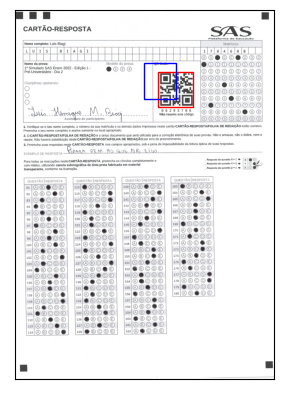

In [58]:
im = imageio.imread(
    "data/omr/test/16486693441271C2B020DIA0015_jpg.rf.0e1bf6636daf6f705d87a521f2ed6543.jpg"
)
gt_box = [
    1335,
    584,
    325.51,
    326,
]
pred_box = [1200, 500, 300, 330]
fig, ax = plt.subplots(1)
ax.imshow(im)

gt_rect = matplotlib.patches.Rectangle(
    (gt_box[0], gt_box[1]),
    gt_box[2],
    gt_box[3],
    linewidth=1,
    edgecolor="r",
    facecolor="none",
)

pred_rect = matplotlib.patches.Rectangle(
    (pred_box[0], pred_box[1]),
    pred_box[2],
    pred_box[3],
    linewidth=1,
    edgecolor="b",
    facecolor="none",
)

ax.add_patch(gt_rect)
ax.add_patch(pred_rect)
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])


In [55]:
im.shape

(3437, 2409, 3)

In [59]:
intersection_over_union(gt_box, pred_box)

(0.2467083370156229, 40590, 164526.26)

For object detection, the IoU is used together some threshold to classify if the prediction was positive or negative for our object identification. So, all the TP, TN, FP and FN, will be set by the utilization of some threshold were the IoU give us positive or negative predictions.

So, here we can calculate the mAP (mean average precision), and for that we just calculate the AP for each class, and after we take the mean of those values, like:


$$
AP_{cat} = 0.958
\newline
AP_{dog} = 0.949
\newline
mAP = (0.958 + 0.949)/2
\newline
mAP = 0.9535
\newline
$$